In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import io

In [2]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
response = requests.get(url)

# ZIP dosyasını aç
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall('ml-100k')  # ZIP'i 'ml-100k' klasörüne çıkar

# Ratings ve Movies dosyalarını yükle
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin1', header=None, 
                     names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + 
                           [f'genre_{i}' for i in range(19)])

In [3]:
print(ratings.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [4]:
print(movies.head())

   item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  genre_0  genre_1  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0        1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0        0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0        1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0        0   

   genre_2  genre_3  genre_4  ...  genre_9  genre_10  genre_11  genre_12  \
0        0        1        1  ...        0         0         0         0   
1     

In [5]:
num_users = ratings['user_id'].nunique()
print("number of users: ",num_users)

number of users:  943


In [6]:
num_items = movies.shape[0]
print("number of items: ",num_items)

number of items:  1682


In [7]:
sparsity = 1 - len(ratings) / (num_users * num_items)
print(f'matrix sparsity: {sparsity:f}')

matrix sparsity: 0.936953


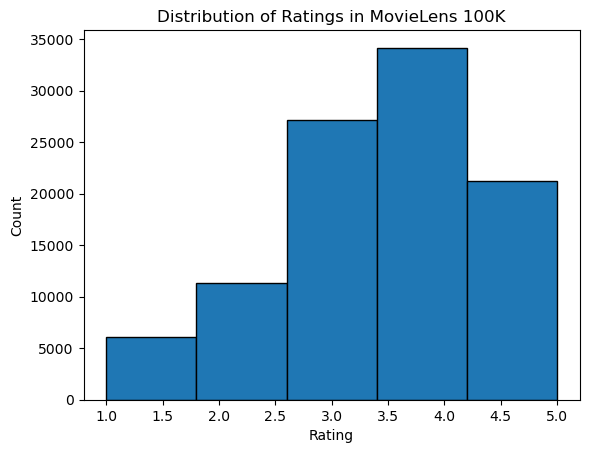

In [8]:
plt.hist(ratings['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

farklı derecelendirmelerin sayısının dağılımını çiziyoruz. Beklendiği gibi, çoğu derecelendirmenin 3-4'te merkezlendiği normal bir dağılım gibi görünüyor.

pd.merge(ratings, movies, on='item_id'): ratings ve movies veri setlerini item_id sütununa göre birleştiriyor. Bu sütun her iki veri setinde de mevcut olduğu için, item_id ile eşleşen satırlar birleştiriliyor.
Yeni ratings veri seti, ratings ve movies veri setlerinin birleşimi olacak. Yani her bir satırda kullanıcı user_id, film item_id, rating, timestamp bilgileriyle birlikte movies veri setinden gelen title sütununu da içerecek.

In [9]:
ratings = pd.merge(ratings, movies, on='item_id')
ratings.head()

,user_id,item_id,rating,timestamp,title,release_date,video_release_date,IMDb_URL,genre_0,genre_1,...,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,0


Kullanıcı-film puan matrisini oluşturma:

Eksik puanlar fillna(0) ile 0 olarak dolduruluyor.

In [10]:
user_item_matrix = ratings.pivot_table(index='user_id',columns='title',values='rating').fillna(0)
user_item_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [11]:
# Let's look at the user ratings of the film Star Wars (1977):

starwars_user_ratings = user_item_matrix['Star Wars (1977)']
starwars_user_ratings.head()

user_id
1    5.0
2    5.0
3    0.0
4    5.0
5    4.0
Name: Star Wars (1977), dtype: float64

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Kullanıcılar arasındaki benzerlikleri hesaplama
similarity_matrix = cosine_similarity(user_item_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

# Kullanıcı benzerliklerini gösterme
print("Kullanıcı Benzerlik Matrisi:")
print(similarity_df.iloc[:,:10])

Kullanıcı Benzerlik Matrisi:
user_id        1         2         3         4         5         6         7   \
user_id                                                                         
1        1.000000  0.168937  0.048388  0.064561  0.379670  0.429682  0.443097   
2        0.168937  1.000000  0.113393  0.179694  0.073623  0.242106  0.108604   
3        0.048388  0.113393  1.000000  0.349781  0.021592  0.074018  0.067423   
4        0.064561  0.179694  0.349781  1.000000  0.031804  0.068431  0.091507   
5        0.379670  0.073623  0.021592  0.031804  1.000000  0.238636  0.374733   
...           ...       ...       ...       ...       ...       ...       ...   
939      0.118722  0.231096  0.026758  0.030202  0.071612  0.112729  0.104394   
940      0.315064  0.228793  0.164539  0.196858  0.239955  0.354454  0.330926   
941      0.149086  0.162911  0.102899  0.152041  0.139595  0.145268  0.060175   
942      0.181612  0.175273  0.136757  0.171538  0.153799  0.312264  0.285273   

num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()

# Kullanıcı ve film matrisini oluştur
user_item_matrix = np.zeros((num_users, num_items))
for line in ratings.itertuples():
    user_item_matrix[line[1]-1, line[2]-1] = line[3]

# Kullanıcı özellik matrisini başlat ve faktorizasyon yap
num_features = 15
learning_rate = 0.01
num_epochs = 100
regularization = 0.02

user_features = np.random.normal(scale=1./num_features, size=(num_users, num_features))
item_features = np.random.normal(scale=1./num_features, size=(num_items, num_features))

def matrix_factorization(user_item_matrix, user_features, item_features, learning_rate, regularization, num_epochs):
    for epoch in range(num_epochs):
        for i in range(num_users):
            for j in range(num_items):
                if user_item_matrix[i, j] > 0:
                    error_ij = user_item_matrix[i, j] - np.dot(user_features[i, :], item_features[j, :].T)
                    user_features[i, :] += learning_rate * (error_ij * item_features[j, :] - regularization * user_features[i, :])
                    item_features[j, :] += learning_rate * (error_ij * user_features[i, :] - regularization * item_features[j, :])
    return user_features, item_features

# Modeli eğit
user_features, item_features = matrix_factorization(user_item_matrix, user_features, item_features, learning_rate, regularization, num_epochs)

# Kullanıcılar arası benzerlik matrisi oluştur
similarity_matrix = cosine_similarity(user_features)

# Öneri fonksiyonu
def recommend_movies(user_id, user_features, item_features, num_recommendations=5):
    user_ratings = np.dot(user_features[user_id - 1], item_features.T)
    rated_items = np.where(user_item_matrix[user_id - 1] > 0)[0]
    user_ratings[rated_items] = -1
    recommended_items = np.argsort(user_ratings)[::-1][:num_recommendations]
    
    print(f"User {user_id} için önerilen filmler:")
    for item_id in recommended_items:
        print(f"Film ID: {item_id + 1} - Tahmin Edilen Puan: {user_ratings[item_id]:.2f}")

# Öneriyi benzer kullanıcıya uygulama
def recommend_for_similar_users(target_user_id, similar_user_id):
    print(f"\nUser {target_user_id} ve User {similar_user_id} benzer.")
    recommend_movies(target_user_id, user_features, item_features)
    recommend_movies(similar_user_id, user_features, item_features)

# En benzer kullanıcıları bul
target_user_id = 1
similar_user_id = 7  # Örnekte id'si 7 olan kullanıcı

# Kullanıcı 1 ve 7 için film öner
recommend_for_similar_users(target_user_id, similar_user_id)

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

ratings['user_id'] -= 1  # index 0'dan başlasın diye güncelleme
ratings['item_id'] -= 1

torch.manual_seed(42)

# Kullanıcı ve öğe sayısını belirle
num_factors = 10  # Gizli faktör sayısı
batch_size = 256

# Matrix Factorization Modeli
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id).squeeze()
        b_i = self.item_bias(item_id).squeeze()
        outputs = (P_u * Q_i).sum(1) + b_u + b_i
        return outputs

# Veri setini hazırlama
class MovieDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.LongTensor(ratings['user_id'].values)
        self.item_ids = torch.LongTensor(ratings['item_id'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.ratings[idx]

In [29]:
train_data = MovieDataset(ratings)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Modeli oluşturma ve eğitim
model = MF(num_factors, num_users, num_items)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Eğitim Döngüsü
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for user_id, item_id, rating in train_loader:
        optimizer.zero_grad()
        pred = model(user_id, item_id)
        loss = loss_fn(pred, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(rating)
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(ratings)}")



# Öneri Sistemi için Fonksiyon
# kullanıcı benzerlikleri dot product yöntemi kullanılarak hesaplanmaktadır.
def recommend_for_user(user_id, top_k=5):
    user_vec = model.P(torch.LongTensor([user_id]))
    similarities = []
    
    for other_user in range(num_users):
        if other_user == user_id:
            continue
        other_vec = model.P(torch.LongTensor([other_user]))
        sim = torch.dot(user_vec.squeeze(), other_vec.squeeze()).item()
        similarities.append((other_user, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    similar_user = similarities[0][0]  # En yüksek benzerlikteki kullanıcı
    similar_user_ratings = ratings[ratings['user_id'] == similar_user]
    top_recommendations = similar_user_ratings.sort_values(by='rating', ascending=False).head(top_k)
    
    print(f"User {user_id} için önerilen filmler:")
    for _, row in top_recommendations.iterrows():
        print(f"Film ID: {row['item_id']}, Puan: {row['rating']} - Benzeyen kullanıcı: {similar_user}")

# Örneğin kullanıcı 1 için öneri yap
recommend_for_user(1)



# Tüm kullanıcı-öğe tahmin matrisini oluştur ve görüntüle
with torch.no_grad():
    user_ids = torch.arange(num_users)
    item_ids = torch.arange(num_items)
    user_embeddings = model.P(user_ids)  # Tüm kullanıcıların embedding matrisi
    item_embeddings = model.Q(item_ids)  # Tüm öğelerin embedding matrisi
    user_bias = model.user_bias(user_ids).squeeze()
    item_bias = model.item_bias(item_ids).squeeze()

    # Kullanıcı-Öğe tahmin matrisini hesapla
    rating_matrix = torch.matmul(user_embeddings, item_embeddings.T) + user_bias.unsqueeze(1) + item_bias.unsqueeze(0)

    print("Kullanıcı-Öğe Tahmin Matrisi:")
    print(rating_matrix)


Epoch 1, Loss: 12.7550702154541
Epoch 2, Loss: 3.294666629104614
Epoch 3, Loss: 1.5806638384628295
Epoch 4, Loss: 1.110685162372589
Epoch 5, Loss: 0.9345080529212951
Epoch 6, Loss: 0.8522522152137756
Epoch 7, Loss: 0.805121302318573
Epoch 8, Loss: 0.7718150698471069
Epoch 9, Loss: 0.7449243119239807
Epoch 10, Loss: 0.7200489537239074
User 1 için önerilen filmler:
Film ID: 97, Puan: 5 - Benzeyen kullanıcı: 315
Film ID: 189, Puan: 5 - Benzeyen kullanıcı: 315
Film ID: 581, Puan: 5 - Benzeyen kullanıcı: 315
Film ID: 426, Puan: 5 - Benzeyen kullanıcı: 315
Film ID: 715, Puan: 5 - Benzeyen kullanıcı: 315
Kullanıcı-Öğe Tahmin Matrisi:
tensor([[3.7733, 3.0196, 3.2024,  ..., 2.2010, 3.5467, 3.1716],
        [3.7555, 3.1745, 3.8035,  ..., 2.5827, 3.8868, 4.3751],
        [2.9408, 2.3818, 3.0054,  ..., 2.2783, 2.1743, 3.0212],
        ...,
        [3.8308, 2.5982, 2.8882,  ..., 0.3862, 2.4352, 1.7204],
        [4.2745, 3.5596, 3.6337,  ..., 3.0921, 4.6384, 4.5472],
        [3.5189, 3.4140, 3.6098,

Matrix Factorization Modeli (MF sınıfı):

MF sınıfında, her kullanıcı ve öğe için gizli faktörler oluşturuluyor (self.P ve self.Q).
Kullanıcı ve öğe özellikleri, nn.Embedding katmanları olarak tanımlanmış ve boyutları num_factors ile belirlenmiş. Bu katmanlar kullanıcı ve öğe etkileşimlerini temsil eden vektörleri içeriyor.
Ayrıca, her kullanıcı ve öğe için ayrı bir önyargı (bias) değeri de eklenmiş (self.user_bias ve self.item_bias).
forward metodunda, user_id ve item_id ile ilgili vektörler alınarak bunlar çarpılıyor ve kullanıcı/öğe önyargıları ekleniyor.
Öğrenme Süreci:

train_loader ile her eğitim adımında kullanıcı-öğe etkileşimleri, MF modeline gönderiliyor.
Model, tahmin edilen puanları (pred) üretiyor ve bu tahminler gerçek puanlarla karşılaştırılarak hata (loss) hesaplanıyor.
loss.backward() ile hata geriye yayılıyor, ardından optimizer.step() ile model parametreleri güncelleniyor.
Bu adımlar, her eğitim döngüsü (epoch) için tekrar ediliyor.
Öneri Fonksiyonu (recommend_for_user):

Bu fonksiyon, belirli bir kullanıcı için öneri yapmak amacıyla kullanılıyor.
recommend_for_user, kullanıcının vektörüne (user_vec) en yakın benzerlik gösteren diğer kullanıcıları buluyor.
En yüksek benzerliğe sahip olan kullanıcının (örneğin similar_user) beğendiği en iyi filmler listelenerek, öneri olarak döndürülüyor.